# Basic Analysis of the ISIC Skin Lesion Images

### via Metadata

<br>

This notebook explores the constituents of the ISIC Skin Lesions data set.  The data set consists of a set of images, a metadata file, and a ground truths file; please read the [project repository](https://github.com/greyhypotheses/derma/tree/develop) or [project proposal](https://docs.google.com/document/d/1i2OWVMBZ6i2IIZFxOKUdUxAOlKXy47cbA0760vKg8ZE/edit?usp=sharing) notes.  The aim herein is to investigate the questions

* What does the metadata relate about the images?
* Is each image associated with a single class only?
* Is the data set balanced or imbalanced?
* Does each lesion class have a sufficient sample size (a) for the stratification of training/testing data if required, (b) per skin lesion class?

The project will programmatically address the possibility of unequal image sizes, and image access failure.


<br>

## PRELIMINARIES

Preparatory steps; importing libraries, importing local classes & methods, logging.



### External Libraries

In [1]:
%matplotlib inline 

import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import matplotlib.image as image
import numpy as np
import requests
import io
import logging


# Setup Seaborn
sns.set_style("darkgrid")
sns.set_context("poster")
sns.set(font_scale=1)

<br>

### Local Classes & Methods

This notebook uses the methods defined in `derma/src/`.  The expression
```python
os.path.split(os.getcwd())[0]
```
is used to retrieve the `derma` path.

In [2]:
sys.path.append( os.path.split(os.getcwd())[0] )

<br>

Hence, local classes & methods can be imported; this minimises code duplication, and aids reproducibility & investigations because the notebook is using same classes that the package's models will use.  The local classes & methods are discussed in context as this notebook's discussion proceeds. 

In [3]:
import src.data.sources as sources
import src.data.usable as usable
import src.data.prepare as prepare
import src.graphing.image as image
import src.cfg.cfg as cfg

<br>

Of import.  The `augmentation` repository, the host of this notebook, has a configurations file reader named `cfg.py`.  It reads the files `src/cfg/variables.yml` & `src/cfg/logs.yml`.

|dictionary|purpose|
|:---|:---|
|variables.json|The dictionary of global variables, e.g., random seed setting for model development, the links to the data sources, etc.|
|logs.json|The dictionary of logging parameters.|

An access example.  If the link to ISIC_2019_Training_Metadata.csv is required, in order to download the file, then 

```python
import pandas as pd
import src.cfg.cfg as cfg

pd.read_csv(cfg.Cfg().variables()['source']['metadata']['url']
```


will read the data into a data frame.

<br>

### Logging

In [4]:
cfg.Cfg().logs()
logging.disable(logging.WARN)

<br>
<br>

## The ISIC Data Set

The ISIC data set consists of 25,331 images; [approximately 9GB](https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_Input.zip).  The metadata and labels of these images are recorded in the files

* https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_Metadata.csv, and
* https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_GroundTruth.csv

respectivey.  To ensure availability, copies of these files and the images are stored in

* https://github.com/greyhypotheses/dermatology/tree/master/data


<br>

### Preview

<br>

The **ISIC_2019_Training_Metadata.csv** file records the name of each image `image`, the approximate age of the patient `age_approx`, the anatomic area wherefrom the image was taken `anatom_site_general`, a lesion identification code `lesion_id`, and the sex of the patient `sex`.  The metadata will not be used for models development, only for (a) understanding the distribution of the images w.r.t. (with respect to) class/label, and potentially important metadata fields, and (b) model evaluation and interpretation.

In [5]:
try:
    metadata = pd.read_csv(cfg.Cfg().variables()['source']['metadata']['url']).head()
except Exception as e:
    print(e)
metadata.head()

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male


<br>

The **ISIC_2019_Training_GroundTruth.csv** file records the label of each image.  The labels are one-hot-coded.  Hence, the first field of the file is the image name field, i.e., `image`, and the remaining columns are the label columns.

In [6]:
try:
    truth = pd.read_csv(cfg.Cfg().variables()['source']['truth']['url']).head()
except Exception as e:
    print(e)
truth.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<br>

The classes/labels are

Name | Abbreviation
--- | ---
Melanoma | MEL
Melanocytic Nevus | NV
Basal Cell carcinoma | BCC
Actinic Keratosis | AK
Benign Keratosis | BKL 
Dermatofibroma | DF
Vascular Lesion | VASC
Squamous Cell Carcinoma | SCC
None of the others | UNK



<br>
<br>

## Observations

### Basic

Methods of the class `src/data/sources.py` read in the metadata & goundtruth data files, and join their data via the image name field `image`.  The `sources.Sources().summary()` method returns 
* a data frame of the merged data `i_listing`; deduplicated. 
* the names of the label columns `i_labels`. 
* the names of the metadata fields `i_fields`. 

In [7]:
i_listing, i_labels, i_fields = sources.Sources().summary()

<br>

The data frame of metadata & ground truths

In [8]:
i_listing.head()

,image,age_approx,anatom_site_general,sex,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,55.0,anterior torso,female,0,1,0,0,0,0,0,0,0
1,ISIC_0000001,30.0,anterior torso,female,0,1,0,0,0,0,0,0,0
2,ISIC_0000002,60.0,upper extremity,female,1,0,0,0,0,0,0,0,0
3,ISIC_0000003,30.0,upper extremity,male,0,1,0,0,0,0,0,0,0
4,ISIC_0000004,80.0,posterior torso,male,1,0,0,0,0,0,0,0,0


<br>

Labels

In [9]:
i_labels

['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']

<br>

Fields

In [10]:
i_fields

['image', 'age_approx', 'anatom_site_general', 'sex']

<br>

There are 25,331 images, hence 25,331 records are expected in `i_listing`.

In [11]:
print(f"Number of records: {i_listing.shape[0]:,}")

Number of records: 25,331


Presently, and temporarily, each time a push to GitHub occurs, the test class test/data/test_Images checks the existence of a random set of images; visit one of [the repository's GitHub Action jobs](https://github.com/greyhypotheses/derma/commit/9dd47bcbcd3f93b0101f4e2ac62b9320d43b2e6b/checks?check_suite_id=329010611), test programs are listed within the `Test with pytest` section.

<br>

**Is each image assigned to a single class/label only?**

In [12]:
# a. Calculate the sum across each row
# b. Check whether the value of each row is 1 
print(f"Each image is assigned to a single class/label: {i_listing[i_labels].sum(axis=1).all()}")

Each image is assigned to a single class/label: True


<br>

### Distribution of Classes

In [13]:
print("The number of instances per class:")
i_listing[i_labels].sum().astype(int)

The number of instances per class:


MEL      4522
NV      12875
BCC      3323
AK        867
BKL      2624
DF        239
VASC      253
SCC       628
UNK         0
dtype: int32

<br>

**The class UNK, i.e., unknown, does not have any data.**  An extension of the `sources.Sources()` class - `usable.Usable()` - is used to filter out records & classes/labels that do not meet a minimum class sample size requirement.

In [14]:
# Presently slow
listing, labels, fields = usable.Usable().summary()

In [15]:
listing.head()

,image,age_approx,anatom_site_general,sex,MEL,NV,BCC,AK,BKL,DF,VASC,SCC
0,ISIC_0000000,55.0,anterior torso,female,0,1,0,0,0,0,0,0
1,ISIC_0000001,30.0,anterior torso,female,0,1,0,0,0,0,0,0
2,ISIC_0000002,60.0,upper extremity,female,1,0,0,0,0,0,0,0
3,ISIC_0000003,30.0,upper extremity,male,0,1,0,0,0,0,0,0
4,ISIC_0000004,80.0,posterior torso,male,1,0,0,0,0,0,0,0


In [16]:
labels

['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']

In [17]:
fields

['image', 'age_approx', 'anatom_site_general', 'sex']

<br>

Hence, the latest distribution of classes is outlined below. The list and graph illustrate an imbalanced dataset. This leads to important modelling considerations

* Stratified data splitting for training & testing.
* Image augmentation to aid cases wherein a class has a small sample size.
* Granular evaluation, e.g., are mis-classifications predominantly associated with classes that have a relatively small sample size (cf. expanded sample size due to augmentation). The insights herein will inform the design of new models.


The number of instances per class:
AK        867
BCC      3323
BKL      2624
DF        239
MEL      4522
NV      12875
SCC       628
VASC      253
dtype: int64
Total: 25,331




Text(0, 0.5, 'Label')

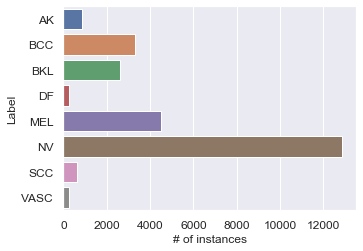

In [18]:
instances_per_class = listing[labels].sum()
instances_per_class.sort_index(inplace=True)

print("The number of instances per class:")
print(instances_per_class)
print(f"Total: {instances_per_class.sum():,}")
print('\n')

plt.figure(figsize=(5.25,3.75))
plt.tick_params(axis='both', labelsize='medium')
sns.barplot(y=instances_per_class.index, x=instances_per_class.values)
plt.xlabel("# of instances", fontsize='medium')
plt.ylabel("Label", fontsize='medium')

<br>
<br>

## The Metadata

The previous section noted that the data set is imbalanced w.r.t. sample sizes per class.  Any imbalances w.r.t. anatomical sites, sex, and/or gender may or may not affect a classification model's performance.  Either way, granular model evaluation w.r.t. these characteristics will be clarifying.  This section conducts a preliminary exploration of skin lesion class distributions w.r.t. these characteristics.  Foremost, missing values are addressed.


The data in focus is `listing`

In [19]:
listing.head()

,image,age_approx,anatom_site_general,sex,MEL,NV,BCC,AK,BKL,DF,VASC,SCC
0,ISIC_0000000,55.0,anterior torso,female,0,1,0,0,0,0,0,0
1,ISIC_0000001,30.0,anterior torso,female,0,1,0,0,0,0,0,0
2,ISIC_0000002,60.0,upper extremity,female,1,0,0,0,0,0,0,0
3,ISIC_0000003,30.0,upper extremity,male,0,1,0,0,0,0,0,0
4,ISIC_0000004,80.0,posterior torso,male,1,0,0,0,0,0,0,0


<br>

The `.info()` print highlights missing values in four fields: `age_approx`, `anatom_site_general`, `lesion_id`, `sex`.  The `.unique()` print indicates that each of these fields has `NaN` values. 

In [20]:
print('\n')
print(listing.info())
print('\n')
[{i: listing[i].unique()} for i in fields]



<class 'pandas.core.frame.DataFrame'>
Int64Index: 25331 entries, 0 to 25330
Data columns (total 12 columns):
image                  25331 non-null object
age_approx             24894 non-null float64
anatom_site_general    22700 non-null object
sex                    24947 non-null object
MEL                    25331 non-null int32
NV                     25331 non-null int32
BCC                    25331 non-null int32
AK                     25331 non-null int32
BKL                    25331 non-null int32
DF                     25331 non-null int32
VASC                   25331 non-null int32
SCC                    25331 non-null int32
dtypes: float64(1), int32(8), object(3)
memory usage: 1.7+ MB
None




[{'image': array(['ISIC_0000000', 'ISIC_0000001', 'ISIC_0000002', ...,
         'ISIC_0073249', 'ISIC_0073251', 'ISIC_0073254'], dtype=object)},
 {'age_approx': array([55., 30., 60., 80., 25., 35., 50., 45., 70., 40., 65., 20., 15.,
         85., nan,  5., 10., 75.,  0.])},
 {'anatom_site_general': array(['anterior torso', 'upper extremity', 'posterior torso',
         'lower extremity', nan, 'lateral torso', 'head/neck',
         'palms/soles', 'oral/genital'], dtype=object)},
 {'sex': array(['female', 'male', nan], dtype=object)}]

<br>

The method `prepare.Prepare().missing()` is used to replace missing values; the default settings are outlined in [variables.yml](../src/cfg/variables.yml).

In [21]:
listing = prepare.Prepare().missing(listing)
listing['age_approx'] = listing.age_approx.astype('int')
print('\n')
print(listing.info())
print('\n')
[{i: listing[i].unique()} for i in fields]



<class 'pandas.core.frame.DataFrame'>
Int64Index: 25331 entries, 0 to 25330
Data columns (total 12 columns):
image                  25331 non-null object
age_approx             25331 non-null int32
anatom_site_general    25331 non-null object
sex                    25331 non-null object
MEL                    25331 non-null int32
NV                     25331 non-null int32
BCC                    25331 non-null int32
AK                     25331 non-null int32
BKL                    25331 non-null int32
DF                     25331 non-null int32
VASC                   25331 non-null int32
SCC                    25331 non-null int32
dtypes: int32(9), object(3)
memory usage: 1.6+ MB
None




[{'image': array(['ISIC_0000000', 'ISIC_0000001', 'ISIC_0000002', ...,
         'ISIC_0073249', 'ISIC_0073251', 'ISIC_0073254'], dtype=object)},
 {'age_approx': array([55, 30, 60, 80, 25, 35, 50, 45, 70, 40, 65, 20, 15, 85,  0,  5, 10,
         75], dtype=int64)},
 {'anatom_site_general': array(['anterior torso', 'upper extremity', 'posterior torso',
         'lower extremity', 'unknown', 'lateral torso', 'head/neck',
         'palms/soles', 'oral/genital'], dtype=object)},
 {'sex': array(['female', 'male', 'unknown'], dtype=object)}]

<br>
<br>

#### Anatomical Sites

These are the patient body sites where the images were taken.  The number of lateral torso, oral/genital, palm/soles images are relatively few, and there are more than 2,500 images of unknown anatomical source.  The unique anatomical sites are

In [22]:
listing.anatom_site_general.value_counts()

anterior torso     6915
lower extremity    4990
head/neck          4587
upper extremity    2910
posterior torso    2787
unknown            2631
palms/soles         398
oral/genital         59
lateral torso        54
Name: anatom_site_general, dtype: int64

<br>

The matrix table & graph below summarise the sample sizes per intersection of anatomical site & class.  For example, 1331 of the melanoma (MEL) images are from the anterior torso part of the body.  It is important to take note of anatomical sites that have few, but not zero, instances; image augmentation may help a little.



                      AK   BCC   BKL   DF   MEL    NV  SCC  VASC  Total
anatom_site_general                                                    
anterior torso        92  1114   445   43  1331  3699  113    78   6915
head/neck            598  1131  1001    0   880   767  174    36   4587
lateral torso          0     0     6    0    14    34    0     0     54
lower extremity       66   462   412  138   796  2876  182    58   4990
oral/genital           0     0    14    0    19    24    0     2     59
palms/soles            6     0     7    0   201   168   13     3    398
posterior torso        4   186   230    2   430  1888   25    22   2787
unknown               22    72   275    4   127  2094    6    31   2631
upper extremity       79   358   234   52   724  1325  115    23   2910


Total # of instances: 25,331




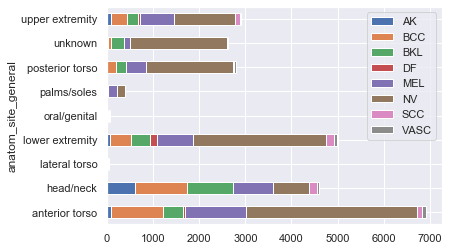

In [23]:
x = listing[['anatom_site_general'] + labels].groupby(by='anatom_site_general').sum().astype(int)
x['Total'] = x.sum(axis=1)
x.sort_index(inplace=True)
print('\n')
print(x)
print('\n')
print(f"Total # of instances: {x.Total.sum():,}")
print('\n')
x[labels].plot(kind='barh', stacked=True)

<br>

#### Sex

The statistics w.r.t. sex are outlined below.  There are 384 images of unknown sex source.  The breakdown by sex & class is



         tally
female   11661
male     13286
unknown    384


          AK   BCC   BKL   DF   MEL    NV  SCC  VASC  Total
sex                                                        
female   406  1317  1134  117  1980  6379  203   125  11661
male     458  2000  1467  122  2461  6225  425   128  13286
unknown    3     6    23    0    81   271    0     0    384




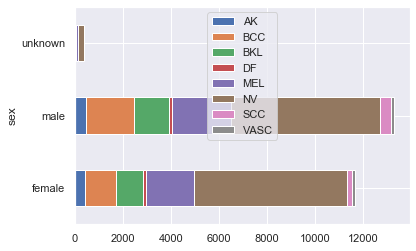

In [24]:
print('\n')
print(pd.DataFrame(listing.sex.value_counts()).rename(columns={'sex': 'tally'}).sort_index())

sex = listing[['sex'] + labels].groupby(by='sex').sum().astype(int)
sex.sort_index(inplace=True)
sex['Total'] = sex.sum(axis=1)

print('\n')
print(sex)
print('\n')
sex[labels].plot(kind='barh', stacked=True)

<br>

#### Age

The distribution of the approximate ages of each lesion's host is outlined below.  The images are predominantly from hosts approximately aged 30 and above.  Although $50.8\%$ of the images - 12,875 of 25,331 images - are Melanocytic Nevus (NV) images, some `age_approx` groups only have a few images within this class.  Whether or not this matters depends on whether lesion pathogenesis has any relationship with age or age group; subject to patient health constraints. 

<br>

    age_approx  tally
0            0    491
1            5    113
2           10    142
3           15    375
4           20    388
5           25    677
6           30   1199
7           35   1651
8           40   2246
9           45   2585
10          50   2489
11          55   2170
12          60   2036
13          65   2075
14          70   2120
15          75   1796
16          80   1459
17          85   1319




Text(0, 0.5, 'tally')

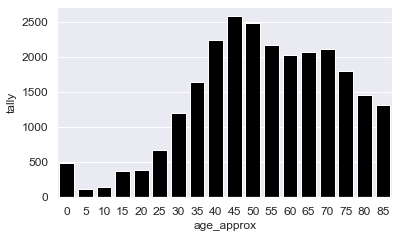

In [25]:
n_per_age_approx = listing['age_approx'].value_counts()

ages = pd.DataFrame(n_per_age_approx).sort_index().reset_index()
ages.rename(columns={'index': 'age_approx', 'age_approx': 'tally'}, inplace=True)

print(ages)
print('\n')

plt.figure(figsize=(6.0,3.5))
plt.tick_params(axis='both', labelsize='medium')
sns.barplot(y=ages.tally, x=ages.age_approx, color='black')
plt.xlabel("age_approx", fontsize='medium')
plt.ylabel("tally", fontsize='medium')

<br>

And at a more granular level

             AK  BCC  BKL  DF  MEL    NV  SCC  VASC
age_approx                                         
0             3    6   31   0   85   362    0     4
5             0    0    1   0    1   108    0     3
10            2    2    0   0    1   135    0     2
15            0    2    0   7    5   355    0     6
20            0   10    7   0   18   349    0     4
25            0   13    5   2   45   606    0     6
30           19   61   43  11  102   955    0     8
35            0   55   57  19  176  1324    3    17
40           15  125  132  32  258  1656    5    23
45            6  170  133  29  373  1832   16    26
50           52  200  197  28  464  1503   27    18
55           63  292  233  32  401  1090   31    28
60          131  293  311  18  410   802   54    17
65          108  382  292  24  478   713   69     9
70          157  443  362  14  570   431  115    28
75          119  431  365   9  383   363   92    34
80          102  397  221   5  391   200  130    13
85          

Text(0, 0.5, 'tally')

<Figure size 432x252 with 0 Axes>

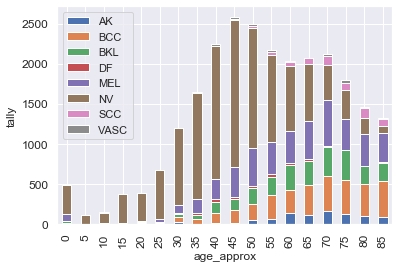

In [26]:
ages_and_labels = listing[['age_approx'] + labels].groupby(by='age_approx').sum().astype(int)

print(ages_and_labels)
print('\n')

plt.figure(figsize=(6.0,3.5))
ages_and_labels.plot(kind='bar', stacked=True)
plt.tick_params(axis='both', labelsize='medium')
plt.xlabel("age_approx", fontsize='medium')
plt.ylabel("tally", fontsize='medium')

<br>
<br>

## A Preview of Skin Lesion Images

<br>

A function that extracts a random sample of images per lesion type

In [27]:
def get_image_names(data, lesiontype, image_name_field, n_images):
    frame = data.loc[data[lesiontype] == 1, [image_name_field]].sample(n_images)
    return frame[image_name_field].to_list()

<br>

An extraction.

In [28]:
images = pd.DataFrame.from_dict( { i:get_image_names(listing, i, 'image', 2) for i in labels } )
images

,AK,BCC,BKL,DF,MEL,NV,SCC,VASC
0,ISIC_0060480,ISIC_0060483,ISIC_0055447,ISIC_0033808,ISIC_0033287,ISIC_0010595,ISIC_0053653,ISIC_0066645
1,ISIC_0061593,ISIC_0072237,ISIC_0029115,ISIC_0032941,ISIC_0058432,ISIC_0025279,ISIC_0069428,ISIC_0027903


<br>

Illustrating; using ``src.graphing.image.Image().draw()``.

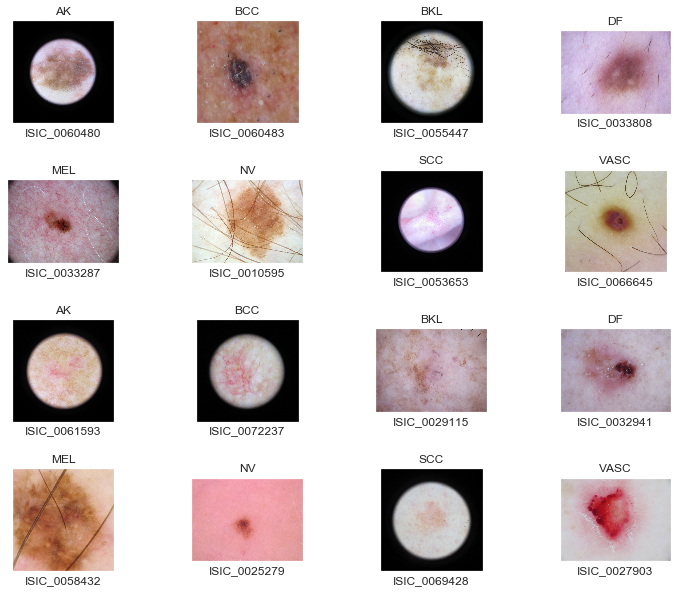

In [29]:
figrows = 4
figcolumns = 4
fig, handle = plt.subplots(figrows, figcolumns, figsize=(11.9, 13.9))
fig.patch.set_visible(False)
  
[image.Image().draw(handle=handle, images=images, datawidth=images.shape[1], index=index, figrows=figrows, figcolumns=figcolumns) 
 for index in range(images.size)]

plt.subplots_adjust(left=0.125, bottom=0.05, right=0.9, top=0.6, wspace=0.65, hspace=0.45)

<br>
<br>

An observation of image sizes; using ``src.graphing.Image.Image().data()``.  Images, or image matrices, of equal sizes are required for the neural network models, hence the different image sizes have to be addressed, carefully.

In [30]:
[image.Image().data(images=images, 
                         datawidth=images.shape[1], index=index).shape for index in range(images.size)]

[(1024, 1024, 3),
 (1024, 1024, 3),
 (1024, 1024, 3),
 (450, 600, 3),
 (450, 600, 3),
 (768, 1024, 3),
 (1024, 1024, 3),
 (1024, 1024, 3),
 (1024, 1024, 3),
 (1024, 1024, 3),
 (450, 600, 3),
 (450, 600, 3),
 (1024, 1024, 3),
 (450, 600, 3),
 (1024, 1024, 3),
 (450, 600, 3)]